In [52]:
# !pip install umap-learn openTSNE
# !conda install -c conda-forge mkl

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
import time
import boto3
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

In [3]:
combined = pd.read_csv('datasets/ealvaradob/combined.csv')

In [4]:
combined.shape

(77677, 3)

In [5]:
combined.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [6]:
combined['label'].value_counts()

label
0    44975
1    32702
Name: count, dtype: int64

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()  # Set model to evaluation mode

2025-05-14 12:28:59.584103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 12:28:59.874300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 12:28:59.935016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 12:28:59.952770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 12:29:00.260400: I tensorflow/core/platform/cpu_feature_guar

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
def get_embeddings(texts, tokenizer, model, batch_size=32, device='cpu'):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state
            mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            masked_embeddings = last_hidden * mask
            summed = masked_embeddings.sum(1)
            counts = mask.sum(1)
            mean_pooled = summed / counts
            embeddings.append(mean_pooled.cpu().numpy())
    return np.vstack(embeddings)

In [9]:
def get_cls_embeddings(texts, tokenizer, model, batch_size=32, device='cpu', log_interval=10):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            # Get [CLS] token embedding for each sequence
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Shape: (batch_size, hidden_size)
            embeddings.append(cls_embeddings)
            # Log progress every 100 batches
            if (i // batch_size) % 100 == 0:
                print(f"[{time.strftime('%X')}] Processed {i + len(batch_texts)} / {len(texts)} records")
    return np.vstack(embeddings)

In [10]:
phish_texts = combined[combined['label'] == 1]['text'].astype(str).tolist()

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

embeddings = get_cls_embeddings(phish_texts, tokenizer, model, batch_size=32, device=device)

[11:08:25] Processed 32 / 32702 records
[11:10:31] Processed 3232 / 32702 records
[11:12:43] Processed 6432 / 32702 records
[11:15:08] Processed 9632 / 32702 records
[11:17:03] Processed 12832 / 32702 records
[11:19:39] Processed 16032 / 32702 records
[11:21:23] Processed 19232 / 32702 records
[11:23:05] Processed 22432 / 32702 records
[11:25:44] Processed 25632 / 32702 records
[11:27:11] Processed 28832 / 32702 records
[11:29:33] Processed 32032 / 32702 records


In [13]:
os.makedirs('embeddings', exist_ok=True)
np.save('embeddings/combined_phish_dataset_bert_embeddings.npy', embeddings)
# Or, to save with your DataFrame:
# df['embedding'] = list(embeddings)
# df.to_pickle('emails_with_embeddings.pkl')

NameError: name 'embeddings' is not defined

In [25]:
not_phish_texts = combined[combined['label'] == 0]['text'].astype(str).tolist()
embeddings = get_cls_embeddings(phish_texts, tokenizer, model, batch_size=32, device=device)
np.save('embeddings/combined_not_phish_dataset_bert_embeddings.npy', embeddings)

[11:30:23] Processed 32 / 32702 records
[11:31:50] Processed 3232 / 32702 records
[11:33:17] Processed 6432 / 32702 records
[11:35:32] Processed 9632 / 32702 records
[11:36:58] Processed 12832 / 32702 records
[11:39:50] Processed 16032 / 32702 records
[11:41:17] Processed 19232 / 32702 records
[11:43:09] Processed 22432 / 32702 records
[11:45:57] Processed 25632 / 32702 records
[11:48:55] Processed 28832 / 32702 records
[11:51:53] Processed 32032 / 32702 records


In [8]:
good_user_embedding_path = "processed/sundar_working/clustering_results/non_phish_body_embeddings.npy"

s3 = boto3.client('s3')

def read_npy_from_s3(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    return np.load(BytesIO(obj['Body'].read()))

# Example usage:
bucket = 'accsec-ai-prod-snitchmail'
good_user_embeddings = read_npy_from_s3(bucket, good_user_embedding_path)

phish_user_embedding_path = "processed/sundar_working/clustering_results/phish_body_embedding_bert_multilingual_uncased.npy"
phish_user_embeddings = read_npy_from_s3(bucket, phish_user_embedding_path)

In [4]:
combined_phish_embeddings = np.load('embeddings/combined_phish_dataset_bert_embeddings.npy')
combined_not_phish_embeddings = np.load('embeddings/combined_not_phish_dataset_bert_embeddings.npy')

In [9]:
good_user_embeddings.shape, phish_user_embeddings.shape, combined_phish_embeddings.shape, combined_not_phish_embeddings.shape

((815148, 768), (5141, 768), (32702, 768), (32702, 768))

## Compare using Mean Embeddings

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute mean embedding for each set
mean_non_phish = np.mean(combined_not_phish_embeddings, axis=0, keepdims=True)
mean_phish = np.mean(combined_phish_embeddings, axis=0, keepdims=True)
mean_good_users = np.mean(good_user_embeddings, axis=0, keepdims=True)
mean_phish_users = np.mean(phish_user_embeddings, axis=0, keepdims=True)

# Compute cosine similarity (higher = more similar)
sim_non_phish = cosine_similarity(mean_non_phish, mean_good_users)[0][0]
sim_phish = cosine_similarity(mean_phish, mean_good_users)[0][0]
sim_phish_non_phish = cosine_similarity(mean_phish, mean_non_phish)[0][0]

sim_not_phish_good_users = cosine_similarity(mean_non_phish, mean_good_users)[0][0]
sim_not_phish_phish_users = cosine_similarity(mean_non_phish, mean_phish_users)[0][0]

sim_phish_users_phish = cosine_similarity(mean_phish, mean_phish_users)[0][0]
sim_phish_users_good_users = cosine_similarity(mean_phish_users, mean_good_users)[0][0]

# print(f"Cosine similarity (Non-Phish vs Good Users): {sim_non_phish:.4f}")
print(f"Cosine similarity (Phish vs Not-Phish): {sim_phish_non_phish:.4f}")
print(f"Cosine similarity (Phish vs Good Users): {sim_phish:.4f}")
print(f"Cosine similarity (Phish vs Phish Users): {sim_phish_users_phish:.4f}")

print(f"Cosine similarity (Not Phish vs Good Users): {sim_not_phish_good_users:.4f}")
print(f"Cosine similarity (Not Phish vs Phish Users): {sim_not_phish_phish_users:.4f}")

print(f"Cosine similarity (Good Users vs Phish Users): {sim_phish_users_good_users:.4f}")

if sim_phish_users_phish < sim_phish:
    print("Phish embeddings are more similar to the Good Users dataset.")
else:
    print("Phish embeddings are more similar to the Phish Users dataset.")


Cosine similarity (Phish vs Not-Phish): 1.0000
Cosine similarity (Phish vs Good Users): 0.0142
Cosine similarity (Phish vs Phish Users): 0.0107
Cosine similarity (Not Phish vs Good Users): 0.0142
Cosine similarity (Not Phish vs Phish Users): 0.0107
Cosine similarity (Good Users vs Phish Users): 0.9978
Phish embeddings are more similar to the Good Users dataset.


## Compare using Mean Cosine Distance
* sample = 5000
* Calculate pairwise cosine distances
* Take average of cosine distances

In [47]:
from sklearn.metrics.pairwise import cosine_distances

# For example, sample 5000 embeddings from each set
n_samples = 5000
idx_non_phish = np.random.choice(len(combined_not_phish_embeddings), n_samples, replace=False)
idx_phish = np.random.choice(len(combined_phish_embeddings), n_samples, replace=False)
idx_good_users = np.random.choice(len(good_user_embeddings), n_samples, replace=False)
idx_phish_users = np.random.choice(len(phish_user_embeddings), n_samples, replace=False)

sample_non_phish = combined_not_phish_embeddings[idx_non_phish]
sample_phish = combined_phish_embeddings[idx_phish]
sample_good_users = good_user_embeddings[idx_good_users]
sample_phish_users = phish_user_embeddings[idx_phish_users]

# Now compute pairwise distances (still O(n^2), but much smaller n)
# avg_dist_non_phish = np.mean(cosine_distances(sample_non_phish, sample_good_users))
avg_dist_phish_non_phish = np.mean(cosine_distances(sample_phish, sample_non_phish))
avg_dist_phish_good_users = np.mean(cosine_distances(sample_phish, sample_good_users))
avg_dist_phish_phish_users = np.mean(cosine_distances(sample_phish, sample_phish_users))
avg_dist_good_users_phish_users = np.mean(cosine_distances(sample_good_users, sample_phish_users))

avg_dist_not_phish_good_users = np.mean(cosine_distances(sample_non_phish, sample_good_users))
avg_dist_not_phish_phish_users = np.mean(cosine_distances(sample_non_phish, sample_phish_users))


# print(f"Average cosine distance (Non-Phish vs Good): {avg_dist_non_phish:.4f}")
print(f"Average cosine distance (Phish vs Non-Phish): {avg_dist_phish_non_phish:.4f}")
print(f"Average cosine distance (Phish vs Good Users): {avg_dist_phish_good_users:.4f}")
print(f"Average cosine distance (Phish vs Phish Users): {avg_dist_phish_phish_users:.4f}")

print(f"Average cosine distance (Not Phish vs Good Users): {avg_dist_not_phish_good_users:.4f}")
print(f"Average cosine distance (Not Phish vs Phish Users): {avg_dist_not_phish_phish_users:.4f}")

print(f"Average cosine distance (Good Users vs Phish Users): {avg_dist_good_users_phish_users:.4f}")

if avg_dist_phish_phish_users < avg_dist_phish_good_users:
    print("Phish embeddings are more similar to the Good dataset.")
else:
    print("Phish embeddings are more similar to the Phish dataset.")


Average cosine distance (Phish vs Non-Phish): 0.2045
Average cosine distance (Phish vs Good Users): 0.9874
Average cosine distance (Phish vs Phish Users): 0.9904
Average cosine distance (Not Phish vs Good Users): 0.9879
Average cosine distance (Not Phish vs Phish Users): 0.9910
Average cosine distance (Good Users vs Phish Users): 0.0178
Phish embeddings are more similar to the Phish dataset.


## Visualize Embeddings using UMap

In [14]:
idx_good = np.random.choice(len(good_user_embeddings), 32000, replace=False)
sample_good = good_user_embeddings[idx_good]

In [18]:
# Concatenate for clustering/visualization
all_embeddings = np.vstack([
                            combined_phish_embeddings
                            , phish_user_embeddings
                            , sample_good]
                          )
labels = (
            ['phish'] * len(combined_phish_embeddings)
          + ['phish-users'] * len(phish_user_embeddings) 
          + ['good-users'] * len(sample_good)
         )

In [16]:
# Dimensionality reduction
import umap.umap_ as umap
reducer = umap.UMAP()
embeddings_2d = reducer.fit_transform(all_embeddings)

/opt/conda/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


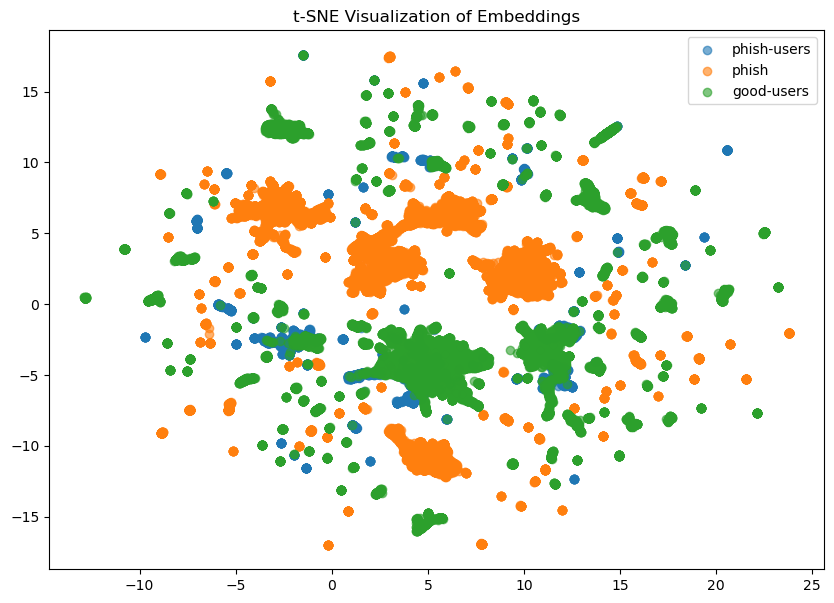

In [19]:
# ALL embeddings
# Plot
plt.figure(figsize=(10, 7))
for label in set(labels):
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=label, alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.show()

## Visualize Embeddings using PCA and KMeans Clustering

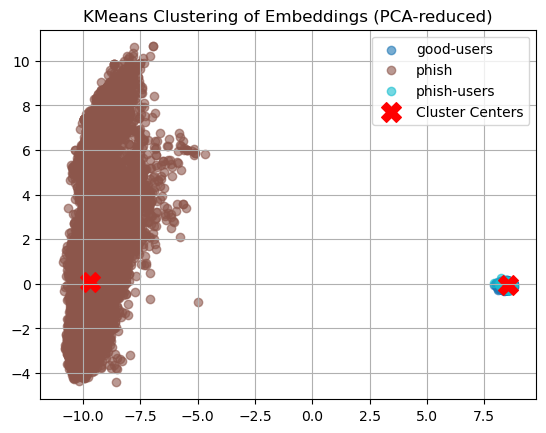

In [24]:
# Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Step 1: Dimensionality reduction with PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(all_embeddings)

# Step 2: KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(all_embeddings)
centers_2d = pca.transform(kmeans.cluster_centers_)

# Step 3: Plotting
unique_labels = sorted(set(labels))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], 
                label=label, alpha=0.6, color=colors[i])
plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    c='red', marker='X', s=200, label='Cluster Centers'
)
plt.title('KMeans Clustering of Embeddings (PCA-reduced)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
our_embeddings = np.vstack([
                            phish_user_embeddings
                            , sample_good]
                          )
our_labels = (
            ['phish-users'] * len(phish_user_embeddings) 
          + ['good-users'] * len(sample_good)
         )

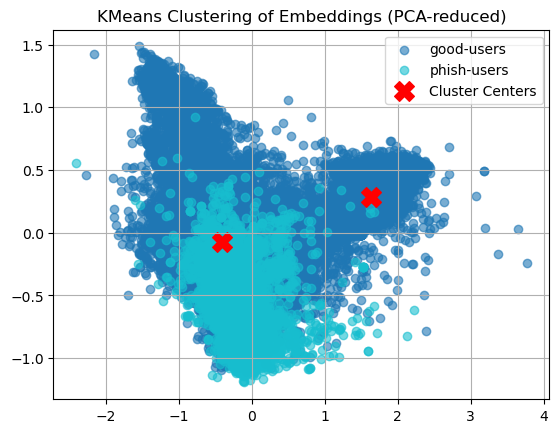

In [36]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(our_embeddings)

# Step 2: KMeans clustering
kmeans = KMeans(n_clusters=2, n_init='auto')
cluster_labels = kmeans.fit_predict(our_embeddings)
centers_2d = pca.transform(kmeans.cluster_centers_)

# Step 3: Plotting
unique_labels = sorted(set(our_labels))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(our_labels) if l == label]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], 
                label=label, alpha=0.6, color=colors[i])
plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    c='red', marker='X', s=200, label='Cluster Centers'
)
plt.title('KMeans Clustering of Embeddings (PCA-reduced)')
plt.legend()
plt.grid(True)
plt.show()

## Visualize our embeddings using UMap

In [28]:
reducer = umap.UMAP()
embeddings_2d = reducer.fit_transform(our_embeddings)

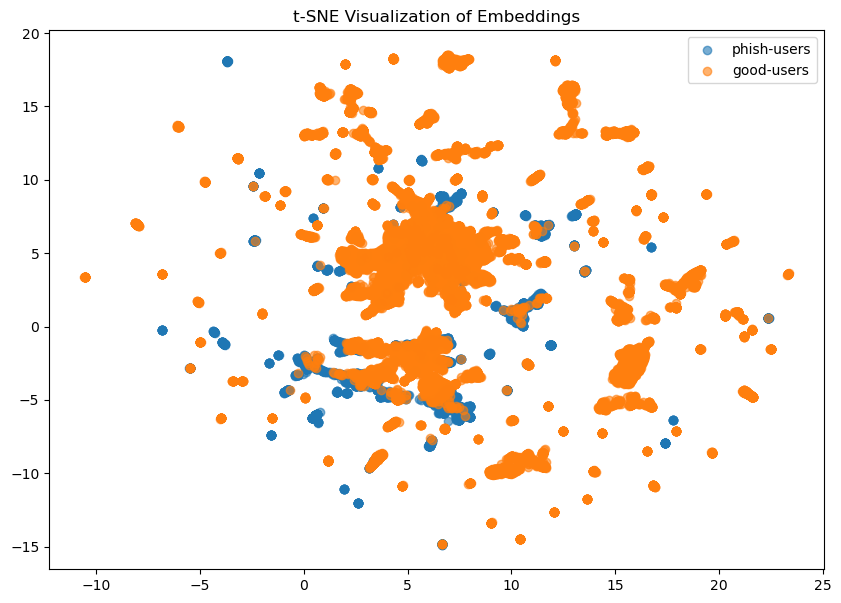

In [29]:
plt.figure(figsize=(10, 7))
for label in set(our_labels):
    idxs = [i for i, l in enumerate(our_labels) if l == label]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=label, alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.show()

## ElSlay - zefang-liu/phishing-email-dataset

In [ ]:
elslay_df = pd.read_csv('datasets/elslay/zefang-liu-elslay_phishing_email_dataset.csv')